# The Impact of Demographics on Campaign Spending and Voting
## Summer 2025 Data Science Project
### Tyshon Brown, David Li, Zile Liu, and Samuel Opoku-Agyemang

## Contributions:
- **Tyshon Brown:** 
    - Population Density vs Voter Turnout Section
    - Extracted County Info for ML (median income, age, total pop)
    - ML Training and Testing
- **David Li:** 
- **Zile Liu:** 
    - Extracted data of funding of the 2020 compaign
    - Performed Chi squared test
- **Samuel Opoku-Agyemang:**
    - Data Curation
    - EDA Hypothesis 1
    - Extracted County Info for ML (total individual contributions)
    - Machine Learning Data Scaling

## Table of Contents:
1. Introduction
2. Data Curation
3. Exploratory Data and Analysis
4. Machine Learning Analysis
5. Final Insights

## 1. Introduction
Contributions from constituents and voters play a very important role in any political campaign, and we wish to explore the relationship between demographics such as age, income, and population (at the county and state level) and political campaign contributions, as well as political election outcomes.

We ask and attempt to answer questions such as
- Which demographics spend the most?
- Which demographics spend the least?
- How much does funding correlate with election outcomes?
- Is there a strong enough relationship between these demographics where we can train a machine learning model to predict outcomes?

We do this using tools from the Python Data Analysis Library and scikit-learn to
- Clean our data and merge into one, well maintained database.
- Explore the relationship between the aformentioned variables.
- Train a predictive machine learning model and test its performance.
- Visualize any trends in a very presentable way.


## 2. Data Curation

We collected and merged the following datasets:
- **Population, Income, and Age** from the 2020 ACS via the `census` Python API.
- **Population density** from [Census Historical Density Tables](https://www.census.gov/data/tables/time-series/dec/density-data-text.html).
- **Campaign finance and expenditures** from the [FEC’s 2020 data archive](https://www.fec.gov/data/).
- **Popular vote totals** by state from the [Federal Elections 2020 report](https://www.fec.gov/introduction-campaign-finance/election-results-and-voting-information/federal-elections-2020/).

We used `pandas`, `scipy`, and `seaborn` for preprocessing and visualization.

In [133]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from census import Census
from us import states
from scipy.stats import chi2_contingency, f_oneway, pearsonr, spearmanr, tukey_hsd
sns.set_theme()
c = Census("23c580dcbb047d99e93502f60681fc6430f2fc9a", year=2020)  # Sam's API key

### State Population

In [134]:
population_data = c.acs5.state(("NAME", "B01003_001E"), Census.ALL)
population = pd.DataFrame(population_data)
population.rename(columns={"NAME": "Name", "B01003_001E": "Population"}, inplace=True)
population["Population"] = population["Population"].astype(int)

population = population.drop("state", axis=1)
population.head()

,Name,Population
0,Pennsylvania,12794885
1,California,39346023
2,West Virginia,1807426
3,Utah,3151239
4,New York,19514849


### Population Density by State

In [135]:
# https://www.census.gov/data/tables/time-series/dec/density-data-text.html
# renamed from "apportionment.csv"
pop_density = pd.read_csv("population_density.csv")
pop_density = pop_density[
    ["Name", "Geography Type", "Year", "Resident Population Density"]
]
pop_density = pop_density[
    (pop_density["Year"] == 2020) & (pop_density["Geography Type"] == "State")
]
pop_density = pop_density[["Name", "Resident Population Density"]].reset_index(
    drop=True
)

# 52 datapoints because DC and Puerto Rico count as states
pop_density.head()

,Name,Resident Population Density
0,Alabama,99.2
1,Alaska,1.3
2,Arizona,62.9
3,Arkansas,57.9
4,California,253.7


### Median Age by State

In [136]:
median_age_dictionary = c.acs5.state(("NAME", "B01002_001E"), Census.ALL)
median_age = pd.DataFrame.from_dict(median_age_dictionary).rename(
    columns={"NAME": "Name", "B01002_001E": "Median Age"}
)
median_age = (
    median_age[["Name", "Median Age"]].sort_values(by=["Name"]).reset_index(drop=True)
)
median_age.head()

,Name,Median Age
0,Alabama,39.2
1,Alaska,34.6
2,Arizona,37.9
3,Arkansas,38.3
4,California,36.7


### Median Income by State

In [137]:
median_income_dictionary = c.acs5.state(("NAME", "B19013_001E"), Census.ALL)
median_income = pd.DataFrame.from_dict(median_income_dictionary).rename(
    columns={"NAME": "Name", "B19013_001E": "Median Household Income"}
)
median_income = (
    median_income[["Name", "Median Household Income"]]
    .sort_values(by=["Name"])
    .reset_index(drop=True)
)
median_income.head()

,Name,Median Household Income
0,Alabama,52035.0
1,Alaska,77790.0
2,Arizona,61529.0
3,Arkansas,49475.0
4,California,78672.0


### Popular Vote by State (Biden v Trump)

In [138]:
# https://www.fec.gov/introduction-campaign-finance/election-results-and-voting-information/federal-elections-2020/
popular_vote = pd.read_csv("federalelections2020.csv")
popular_vote.head()

,Name,Biden Votes,Trump Votes,Total Votes
0,Alabama,849624,1441170,2323282
1,Alaska,153778,189951,359530
2,Arizona,1672143,1661686,3387326
3,Arkansas,423932,760647,1219069
4,California,11110639,6006518,17501380


### 2020 Election Candidate Funding

In [139]:
## Source: https://www.fec.gov/resources/campaign-finance-statistics/2020/tables/ie/IE2_2020_24m.pdf
independent_expenditure = pd.read_csv("candidates_funding.csv")
independent_expenditure = independent_expenditure.sort_values(
    by=["Total IEs For"], ascending=False
)
independent_expenditure.index = range(0, len(independent_expenditure))
independent_expenditure.head()

,Candidate,Total IEs For,Total IEs Against
0,"Biden, Joseph R Jr",383204094,299388312
1,"Trump, Donald J.",53500635,308135887
2,"Warren, Elizabeth",14996979,18965
3,"Buttigieg, Pete",3668912,30862
4,"Klobuchar, Amy J.",2711204,101


### State Contributions

In [140]:
state_contributions = pd.read_csv("state_spending.csv")
state_contributions = state_contributions.rename(
    columns={"State (or District)": "Name"}
).drop(columns=["Rank"])
state_contributions["Total Contributions"] = (
    state_contributions["Total Contributions"].str.replace("$", "").astype(int)
)
state_contributions["Percent to Democrats"] = (
    state_contributions["Percent to Democrats"].str.replace("%", "").astype(float) / 100
)
state_contributions["Percent to Republicans"] = (
    state_contributions["Percent to Republicans"].str.replace("%", "").astype(float)
    / 100
)
state_contributions["Contributions to Democrats"] = (
    state_contributions["Total Contributions"]
    * state_contributions["Percent to Democrats"]
)
state_contributions["Contributions to Republicans"] = (
    state_contributions["Total Contributions"]
    * state_contributions["Percent to Republicans"]
)
state_contributions.head()

,Name,Total Contributions,Percent to Democrats,Percent to Republicans,Contributions to Democrats,Contributions to Republicans
0,California,1666572970,0.6931,0.2842,1.155102e+09,4.736400e+08
1,New York,978988661,0.7462,0.2318,7.305213e+08,2.269296e+08
2,District of Columbia,810155426,0.6701,0.3148,5.428852e+08,2.550369e+08
3,Texas,687622660,0.3488,0.6315,2.398428e+08,4.342337e+08
4,Florida,646468276,0.3692,0.6108,2.386761e+08,3.948628e+08


## 3. Exploratory Data Analysis

We conducted exploratory analysis to test the following three hypotheses:

1. **Does median age correlate with political funding outcomes?**  
   Specifically, do older states tend to contribute more to Republican or Democratic candidates?

2. **Does population density correlate with voter turnout?**  
   We explored whether people in more densely populated states are more likely to vote.

3. **Does campaign spending correlate with election success?**  
   In particular, do top-funded candidates consistently secure more votes, and is the relationship statistically significant?

To answer these, we:
- Merged and cleaned datasets from the **U.S. Census Bureau** and the **FEC**.
- Performed statistical tests including **ANOVA**, **Tukey's HSD**, **Pearson and Spearman correlation**, and **Chi-Square** tests.
- Created scatterplots, regression lines, and bar graphs to visualize relationships.
- Used state-level data for the 2020 U.S. presidential election to ensure consistency and completeness.

Each method helped us characterize the data, identify patterns, and evaluate the strength of relationships between variables. See the subsections below for details, plots, and conclusions.

### **Hypothesis 1**: Does median age correlate with political funding outcomes?

We performed a one-way ANOVA and a Tukey's honest significant difference test. Our null hypothesis is that the proportion of contributions to Democrats/Republicans from a state is independent of its median age.

In [141]:
joint_df = pd.merge(left=median_age, right=state_contributions, how="inner")
joint_df = pd.merge(left=joint_df, right=population, how="inner")
joint_df.insert(
    2,
    "Age Group",
    pd.qcut(joint_df["Median Age"], q=3, labels=["Lower", "Medium", "Higher"]),
)

lower = joint_df[joint_df["Age Group"] == "Lower"]["Percent to Republicans"]
medium = joint_df[joint_df["Age Group"] == "Medium"]["Percent to Republicans"]
higher = joint_df[joint_df["Age Group"] == "Higher"]["Percent to Republicans"]

statistic, p_value = f_oneway(lower, medium, higher)
print(f"ANOVA statistic: {statistic:.4f}, ANOVA p-value: {p_value:.4f}")
# significant, so we proceed with a post-hoc Tukey's HSD
print(tukey_hsd(lower, medium, higher))

ANOVA statistic: 5.3387, ANOVA p-value: 0.0081
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.064     0.481    -0.069     0.197
 (0 - 2)      0.178     0.006     0.045     0.311
 (1 - 0)     -0.064     0.481    -0.197     0.069
 (1 - 2)      0.114     0.109    -0.020     0.247
 (2 - 0)     -0.178     0.006    -0.311    -0.045
 (2 - 1)     -0.114     0.109    -0.247     0.020



#### *Visual: Median Age and Percent to Republican Candidates (ANOVA, Tukey's HSD, Regresison)*

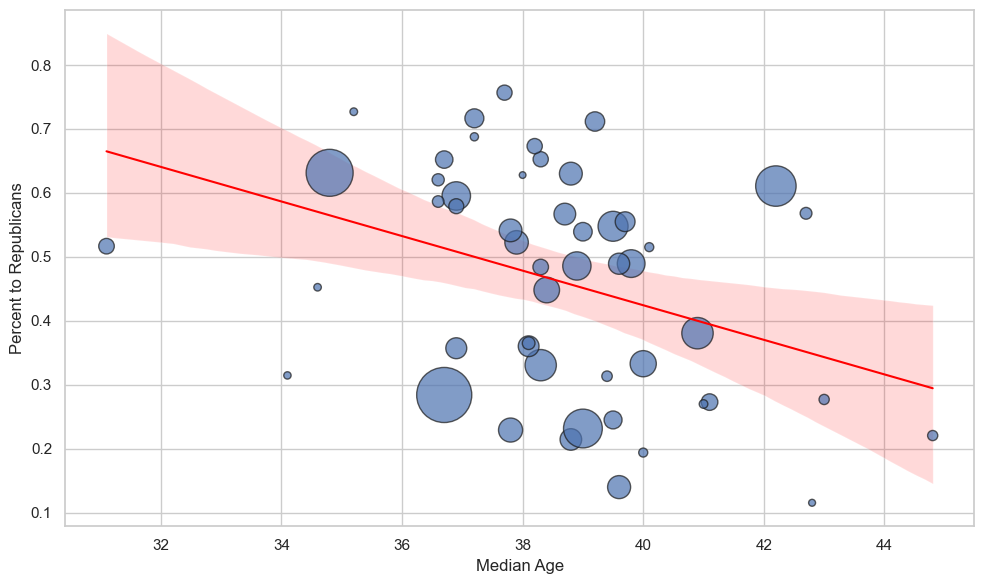

In [142]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Regression Line
sns.regplot(
    data=joint_df,
    x="Median Age",
    y="Percent to Republicans",
    scatter=False,
    color="red",
    line_kws={"linewidth": 1.5},
)

# Scatter Plot
plt.scatter(
    x=joint_df["Median Age"],
    y=joint_df["Percent to Republicans"],
    s=joint_df["Population"] / 25000,
    alpha=0.7,
    edgecolor="k",
)
plt.tight_layout()
plt.show()

#### *Visual: Median Age and Percent to Democratic Candidates (Plot & Regression)*

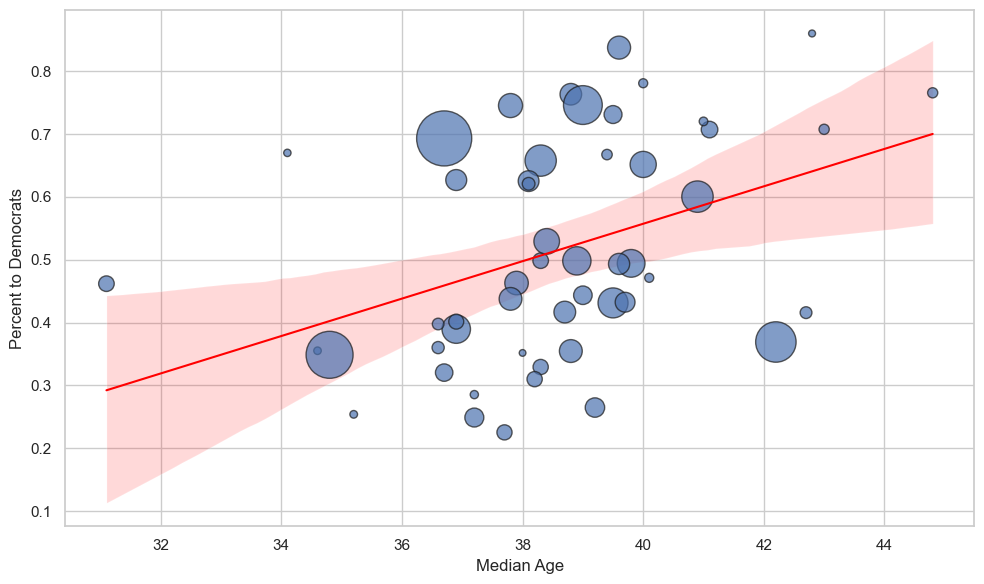

In [143]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Regression Line
sns.regplot(
    data=joint_df,
    x="Median Age",
    y="Percent to Democrats",
    scatter=False,
    color="red",
    line_kws={"linewidth": 1.5},
)

# Scatter Plot
plt.scatter(
    x=joint_df["Median Age"],
    y=joint_df["Percent to Democrats"],
    s=joint_df["Population"] / 25000,
    alpha=0.7,
    edgecolor="k",
)
plt.tight_layout()
plt.show()

#### Conclusion for Hypothesis 1:

There is statistically significant evidence that median age is associated with differences in political contribution patterns across states.
- The one-way **ANOVA** results in a statistic of 5.34 and a p-value of 0.0081, indicating we can reject the null hypothesis at the 1% level. This means that the proportion of contributions to political parties is not independent of median age.
- The **Tukey's HSD** post-hoc test shows that the largest difference in contribution patterns exists between group 0 (younger age group) and group 2 (older age group), with a statistically significant difference (p = 0.006, 95% CI = [0.045, 0.311]).
- The **scatter plots** show:
    - A negative trend between median age and percent of contributions to Republicans, suggesting that states with older populations may tend to contribute less to Republican candidates.
    - A positive trend between median age and percent of contributions to Democrats, suggesting that states with older populations may tend to contribute more to Democratic candidates.

### **Hypothesis 2**: Does population density correlate to voter turnout? (Pearsons Coefficient, Spearman Coefficient, Regression)

We performed a simple linear regression. We use Pearson and Spearman correlation analyses to test the null hypothesis that a state's voter turnout is independent of its population density.

#### Turnout Rate:

In [144]:
merged_pop_df = popular_vote.merge(population, on="Name")
merged_pop_df["Turnout"] = merged_pop_df["Total Votes"] / merged_pop_df["Population"]

# popular_vote['Turnout'] = popular_vote['Total Votes'] / population['Population']
merged_pop_df.head(5)

,Name,Biden Votes,Trump Votes,Total Votes,Population,Turnout
0,Alabama,849624,1441170,2323282,4893186,0.474799
1,Alaska,153778,189951,359530,736990,0.487836
2,Arizona,1672143,1661686,3387326,7174064,0.472163
3,Arkansas,423932,760647,1219069,3011873,0.404754
4,California,11110639,6006518,17501380,39346023,0.444807


#### Merging the dataframes for visualization:

In [145]:
# merging Popular Vote and Population Density and Population
density_turnout = merged_pop_df.merge(pop_density, on="Name")

# Calculating turnout and adding it to the df
density_turnout["Turnout"] = (
    density_turnout["Total Votes"] / density_turnout["Population"] * 100
)
density_turnout["Resident Population Density"] = pd.to_numeric(
    density_turnout["Resident Population Density"], errors="coerce"
)

# Dropping Na's
density_turnout = density_turnout.dropna(
    subset=["Resident Population Density", "Turnout"]
)

density_turnout.head()

,Name,Biden Votes,Trump Votes,Total Votes,Population,Turnout,Resident Population Density
0,Alabama,849624,1441170,2323282,4893186,47.479945,99.2
1,Alaska,153778,189951,359530,736990,48.783566,1.3
2,Arizona,1672143,1661686,3387326,7174064,47.216278,62.9
3,Arkansas,423932,760647,1219069,3011873,40.475445,57.9
4,California,11110639,6006518,17501380,39346023,44.480684,253.7


#### The Plot:
- x-axis: Population Density
- y-axis: Voter Turnout
- blue dots/points: scaled to the population size
- red regression line

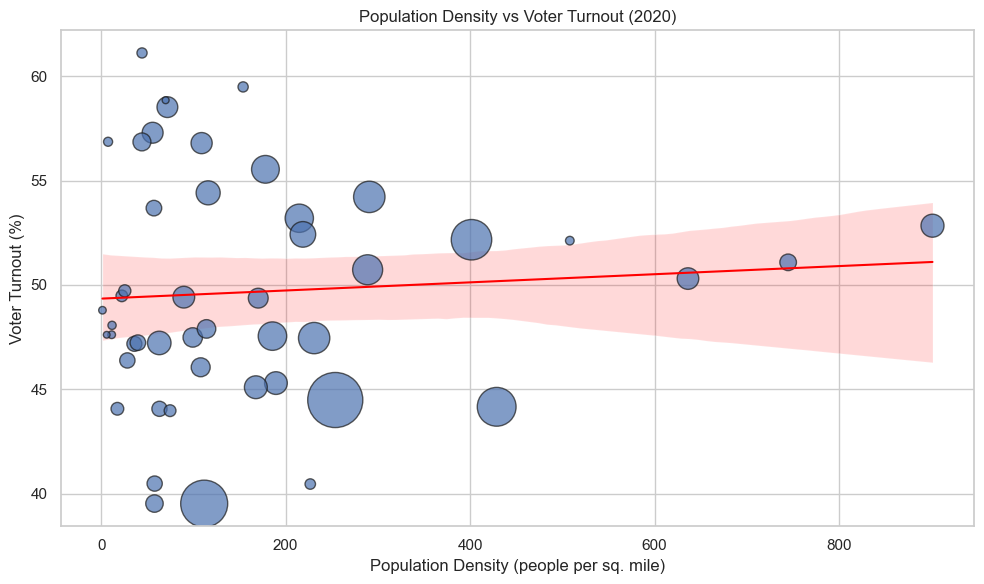

Pearson correlation: 0.070, p-value: 0.636
Spearman correlation: 0.051, p-value: 0.733


In [146]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Regression Line
sns.regplot(
    data=density_turnout,
    x="Resident Population Density",
    y="Turnout",
    scatter=False,
    color="red",
    line_kws={"linewidth": 1.5},
)


# Scatter Plot
plt.scatter(
    x=density_turnout["Resident Population Density"],
    y=density_turnout["Turnout"],
    s=density_turnout["Population"] / 25000,
    alpha=0.7,
    edgecolor="k",
)

plt.xlabel("Population Density (people per sq. mile)")
plt.ylabel("Voter Turnout (%)")
plt.title("Population Density vs Voter Turnout (2020)")
plt.tight_layout()
plt.show()

# Pearson Correlation
p_corr, p_p = pearsonr(
    density_turnout["Resident Population Density"], density_turnout["Turnout"]
)
print(f"Pearson correlation: {p_corr:.3f}, p-value: {p_p:.3g}")

# Spearman Correlation
s_corr, s_p = spearmanr(
    density_turnout["Resident Population Density"], density_turnout["Turnout"]
)
print(f"Spearman correlation: {s_corr:.3f}, p-value: {s_p:.3g}")

#### Conclusion for Hypothesis 2:

There is no significant correlation between population density and voter turnout across states.
- The **Pearson** correlation coefficient is 0.070 and the **Spearman** correlation coefficient is 0.051. Both indicating a very weak positive relationship.
- The p-values for both tests exceed 0.05, meaning the correlations are not statistically significant.
- We therefore fail to reject the null hypothesis that population density and voter turnout are unrelated.
- This finding is also supported by the scatter plot, which shows no clear trend or pattern between the two variables.

### Hypothesis 3: Does campaign spending correlate with election success? (Pearson's Chi-square)

For simplicity, we would just use Total IEs in this test, and we only decided to display the top 4 candidates who received most fund.

,Candidate,Total IEs For,Total IEs Against
0,"Biden, Joseph R Jr",383204094,299388312
1,"Trump, Donald J.",53500635,308135887
2,"Warren, Elizabeth",14996979,18965
3,"Buttigieg, Pete",3668912,30862
4,"Klobuchar, Amy J.",2711204,101


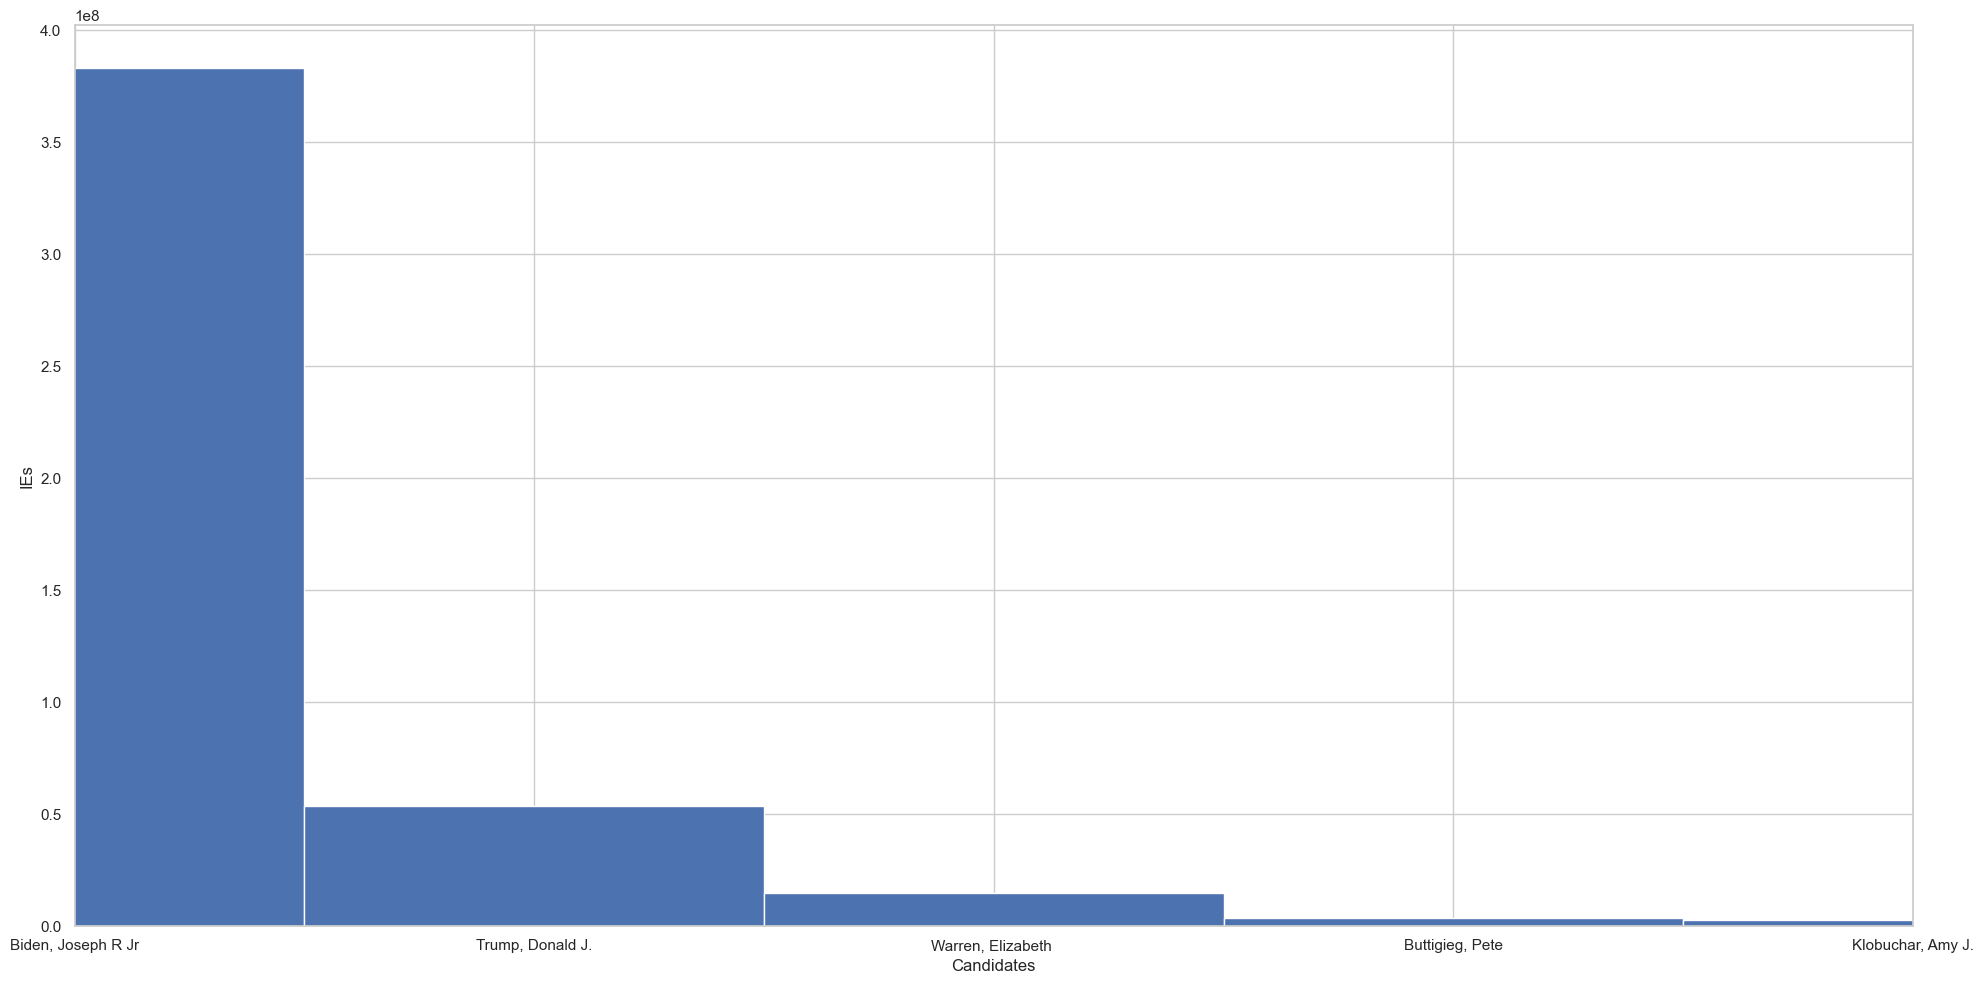

In [147]:
display(independent_expenditure.head())
independent_expenditure = independent_expenditure[["Candidate", "Total IEs For"]]
plt.figure(figsize=(20, 10))
plt.bar(
    independent_expenditure["Candidate"],
    independent_expenditure["Total IEs For"],
    width=1,
)
plt.xlabel("Candidates")
plt.ylabel("IEs")
plt.xlim(0, 4)
plt.tight_layout()
plt.show()

#### Chi-Square Test:

In [148]:
df = independent_expenditure.copy()
signifs = ["Biden, Joseph R Jr", "Trump, Donald J."]
df["Group"] = np.where(df["Candidate"].isin(signifs), "Top2", "Others")
df["SpendCat"] = df["Total IEs For"].apply(lambda x: "High" if x > 20000000 else "Low")
table = pd.crosstab(df["Group"], df["SpendCat"])
chi2, p_value, dof, expected = chi2_contingency(table)
print(f"P-value: {p_value}")

P-value: 4.23797729142689e-06


#### Conclusion for Hypothesis 3:
- The chi-square test yielded a p-value of 4.24e-06, which is well below the standard alpha level of 0.05. This allows us to reject the null hypothesis, indicating a statistically significant correlation between a candidate’s level of campaign spending and their success.
- The bar graph visually reinforces this conclusion: the top-performing candidates in the election (e.g., Biden and Trump) also received the highest levels of independent expenditures, while less competitive candidates received less.

## 4. Machine Learning Analysis

We will use a Model to predict total campaign contributions using
- Median Household Income
- Median Age
- Total Population

This model helps us understand how demographic factors influence financial engagement in U.S. elections. Initially we collected this data based only on states.
But we realized that 50 state sample size was too small for reliable machine learning. To improve our model, we expanded to county-level data.

This model would offer value to campaigns:
- Candidates can identify high-potential fundraising areas based on local demographics
- Instead of targeting entire states, campaigns can prioritize specific counties likely to yield more contributions

**Overall, this approach transforms demographics into a predictive fundraising map, helping campaigns allocate resources more effectively based on data.**

### **County** Median Age, Income, and Total Population

In [149]:

all_counties = []
# Variables:
# B19013_001E → Median Household Income
# B01003_001E → Total Population
# B01002_001E → Median Age
variables = ("NAME", "B19013_001E", "B01003_001E", "B01002_001E")

for state in states.STATES:
    try:
        county_data = c.acs5.get(
            variables,
            {'for': 'county:*', 'in': f'state:{state.fips}'}
        )
        for row in county_data:
            row['state_name'] = state.name #state name is included
        all_counties.extend(county_data)
    except Exception as e:
        print(f"Error retrieving data for {state.name}: {e}")

county_df = pd.DataFrame(all_counties)
county_df.rename(columns={
    "NAME": "County Name",
    "B19013_001E": "Median Income",
    "B01003_001E": "Population",
    "B01002_001E": "Median Age",
    "state": "State FIPS",
    "county": "County FIPS",
    "state_name": "State"
}, inplace=True)

# Convert to numeric
for col in ["Median Income", "Population", "Median Age"]:
    county_df[col] = pd.to_numeric(county_df[col], errors='coerce')


In [150]:
print(county_df.shape)
county_df.head(100)

(3142, 7)


,County Name,Median Income,Population,Median Age,State FIPS,County FIPS,State
0,"Autauga County, Alabama",57982.0,55639.0,38.6,01,001,Alabama
1,"Baldwin County, Alabama",61756.0,218289.0,43.2,01,003,Alabama
2,"Barbour County, Alabama",34990.0,25026.0,40.1,01,005,Alabama
3,"Bibb County, Alabama",51721.0,22374.0,39.9,01,007,Alabama
4,"Blount County, Alabama",48922.0,57755.0,41.0,01,009,Alabama
...,...,...,...,...,...,...,...
95,"Prince of Wales-Hyder Census Area, Alaska",54018.0,6338.0,42.1,02,198,Alaska
96,"Southeast Fairbanks Census Area, Alaska",66941.0,6911.0,36.8,02,240,Alaska
97,"Apache County, Arizona",33967.0,71714.0,35.4,04,001,Arizona
98,"Cochise County, Arizona",51505.0,126442.0,41.0,04,003,Arizona


### Individual Contributions

In [151]:
import zipcodes
import re

# https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
state_names = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
    
    'AS': 'American Samoa',
    'DC': 'District of Columbia',
    'GU': 'Guam',
    'MP': 'Northern Mariana Islands',
    'PR': 'Puerto Rico',
    'VI': 'U.S. Virgin Islands',
    
    'AA': 'Armed Forces Americas',
    'AE': 'Armed Forces Europe',
    'AP': 'Armed Forces Pacific'
}

def zip_to_state(zip_code):
    if zip_code:
        matches = zipcodes.matching(zip_code)
        return matches[0]['state'] if matches else None
    else:
        return None

# County Name, State
def zip_to_county(zip_code):
    matches = zipcodes.matching(zip_code)
    if matches:
        if matches[0]['county'] and (matches[0]['state'] in state_names):
            return matches[0]['county'] + ", " + state_names[matches[0]['state']]
        else:
            return None
    else:
        return None

def clean_zip(zip_code):
    if zip_code is None or pd.isna(zip_code):
        return None
    
    zip_code = str(zip_code).strip()

    if not re.fullmatch(r'\d+', zip_code):
        return None
    
    return zip_code[:5].zfill(5)


#### Sampling Individual Contributions
There were over 69 million campaign total campaign contributions for the 2020 election cycle, and to cope our current technical limitations, we use only a portion of these. Our data is restricted to the time period of 2020-09-02 to 2020-11-26, the time closest to the elections where we believe the most important political activity would occur.

In [152]:
header = [
    "CMTE_ID",
    "AMNDT_IND",
    "RPT_TP",
    "TRANSACTION_PGI",
    "IMAGE_NUM",
    "TRANSACTION_TP",
    "ENTITY_TP",
    "NAME",
    "CITY",
    "STATE",
    "ZIP_CODE",
    "EMPLOYER",
    "OCCUPATION",
    "TRANSACTION_DT",
    "TRANSACTION_AMT",
    "OTHER_ID",
    "TRAN_ID",
    "FILE_NUM",
    "MEMO_CD",
    "MEMO_TEXT",
    "SUB_ID"
]

# data from https://www.fec.gov/data/browse-data/?tab=bulk-data, contributions by individuals
files = [
    "by_date/itcont_2020_20200902_20200911.txt", 
    "by_date/itcont_2020_20200912_20200919.txt",
    "by_date/itcont_2020_20200920_20200925.txt",
    "by_date/itcont_2020_20200926_20200930.txt",
    "by_date/itcont_2020_20200930_20201004.txt",
    "by_date/itcont_2020_20201005_20201010.txt",
    "by_date/itcont_2020_20201011_20201014.txt",
    "by_date/itcont_2020_20201015_20201018.txt",
    "by_date/itcont_2020_20201019_20201022.txt",
    "by_date/itcont_2020_20201023_20201026.txt",
    "by_date/itcont_2020_20201027_20201030.txt",
    "by_date/itcont_2020_20201030_20201101.txt",
    "by_date/itcont_2020_20201102_20201106.txt",
    "by_date/itcont_2020_20201107_20201115.txt",
    "by_date/itcont_2020_20201116_20201126.txt"
]

# chunks = []
# i = 1
# for file in files:
#     chunk = pd.read_csv(file, sep = '|', names = header, on_bad_lines = 'skip', usecols=['ZIP_CODE', 'TRANSACTION_AMT'])
#     chunk = chunk.dropna(how = 'any')
    
#     # cleaning zip codes
#     chunk = chunk[~chunk['ZIP_CODE'].isin(["00000", "000.0"])]
#     chunk.loc[:, 'ZIP_CODE'] = chunk['ZIP_CODE'].apply(clean_zip)

#     # cleaning transaction amounts
#     chunk.loc[:, 'TRANSACTION_AMT'] = pd.to_numeric(chunk['TRANSACTION_AMT'], errors = 'coerce', downcast = 'integer')
#     chunk = chunk.dropna(subset = ['TRANSACTION_AMT'])

#     # grouping and summing by zip code
#     grouped_df = chunk.groupby('ZIP_CODE').agg({'TRANSACTION_AMT': 'sum'}).reset_index()

#     # adding county column
#     grouped_df.loc[:, 'COUNTY'] = grouped_df['ZIP_CODE'].apply(zip_to_county)

#     # final processing and exporting
#     grouped_by_county_df = grouped_df.groupby('COUNTY').agg({'TRANSACTION_AMT' : 'sum'})
    
#     chunks.append(grouped_by_county_df)
#     print(f"{(i / 15):.4%}")
#     i += 1

# sept_to_nov_df = pd.concat(chunks).groupby('COUNTY').agg({'TRANSACTION_AMT' : 'sum'})
# sept_to_nov_df = sept_to_nov_df.rename(columns={'COUNTY' : 'County Name', 'TRANSACTION_AMT' : 'Contributions'})

# contributions_df = pd.read_csv("individual_contributions.csv")
# print(contributions_df.shape)


In [153]:
contributions_df = pd.read_csv("sept_to_nov.csv").rename(columns={'COUNTY' : 'County Name', 'TRANSACTION_AMT' : 'Contributions'})
contributions_df.head()

,County Name,Contributions
0,"Abbeville County, South Carolina",31868.0
1,"Acadia Parish, Louisiana",52030.0
2,"Accomack County, Virginia",139421.0
3,"Ada County, Idaho",5564755.0
4,"Adair County, Iowa",13036.0


### MLPRegressor

We opted to train our data on a MLPRegressor model over a Linear Regression as we expect for the relationship between the inputs and outputs to be slightly non-linear.
The increased complexity gained from choosing MLPRegressor also allows for our model to better cope with the restricted data.

Our data was scaled using the logistic and standard scaling as there were outliers that we needed to account for before training, fitting, and testing our model.

In [154]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

machine_learning_df = pd.merge(county_df[['County Name', 'Median Income', 'Median Age', 'Population']], contributions_df, on = 'County Name', how = 'inner')
machine_learning_df = machine_learning_df[0 <= machine_learning_df["Contributions"]]

In [155]:
# scaling using inter-quartile range
q1 = machine_learning_df["Contributions"].quantile(0.25)
q3 = machine_learning_df["Contributions"].quantile(0.75)
iqr = q3 - q1
machine_learning_df = machine_learning_df[q1 - 1.5*iqr <= machine_learning_df["Contributions"]]
machine_learning_df = machine_learning_df[machine_learning_df["Contributions"] <= q3 + 1.5*iqr ]


/home/samuel/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


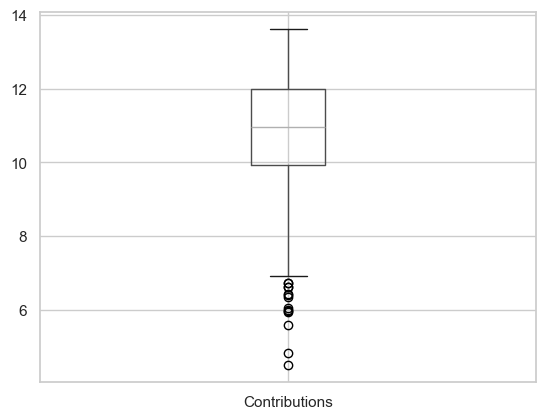

In [156]:
# taking the log to further account for outliers
machine_learning_df = np.log1p(machine_learning_df[['Median Income', 'Median Age', 'Population', 'Contributions']])
machine_learning_df = machine_learning_df.dropna(how = 'any')
machine_learning_df.boxplot(column=['Contributions'])
plt.show()

In [ ]:
# train, test, split
X = machine_learning_df[['Median Income', 'Median Age', 'Population']]
y = machine_learning_df['Contributions']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify=pd.qcut(y, q=5))

In [158]:
# standard scaling
scaler_X = StandardScaler().fit(X_train)    
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [159]:
# standard scaling
scaler_y = StandardScaler().fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

With a set seed, our model has a $R^2$ coefficient of determination of $0.747$, meaning that $74.7\%$ of the variance in $Y$ can be explained by $X$. The alpha parameter controls the strength of the L2 regularization term, and this was increased from its base value of $0.0001$ to $0.1$ to decrease the amount of overfitting and thus generalize the model better.

In [ ]:
# building and fitting model
regressor = MLPRegressor( hidden_layer_sizes=(128, 64, 32), alpha=0.1, max_iter=3000, random_state=42)
regressor.fit(X_train_scaled, y_train_scaled)

,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.1
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,3000
,shuffle,True


In [161]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

# predicting
y_pred_scaled = regressor.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# statistical tests
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 0.4861
R-squared: 0.7515
Root Mean Squared Error: 0.6972


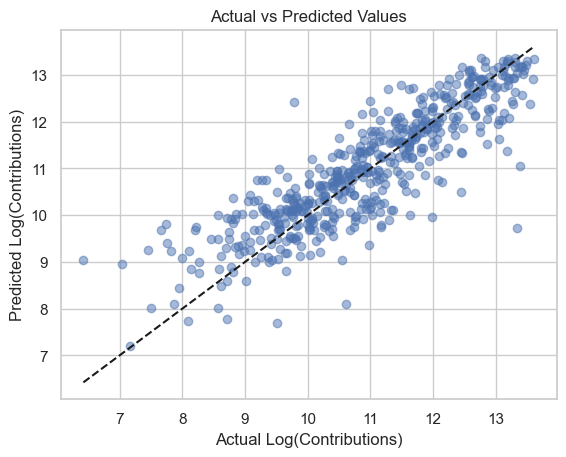

In [162]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Log(Contributions)')
plt.ylabel('Predicted Log(Contributions)')
plt.title('Actual vs Predicted Values')
plt.show()

In [163]:
print(f"Train score (R²): {regressor.score(X_train_scaled, y_train_scaled):.4f}")
print(f"Test score (R²): {regressor.score(X_test_scaled, y_test_scaled):.4f}")

Train score (R²): 0.7635
Test score (R²): 0.7515


In [ ]:
print(f"Median Contribution: {machine_learning_df["Contributions"].median()}")

### Model Analysis

To assess the effectiveness of our predictive model, we trained a Multi-Layer Perceptron (MLP) regressor to estimate total campaign contributions at the county level, using only three input features:
- Median income
- Median age
- Total population

##### Performance Metrics

| Metric | Value |
|----------|----------|
| Train $R^2$ Score | $0.7635$  |
| Test $R^2$ Score  | $0.7515$ |
| Root MSE  | $15,852.44 |

<!-- - The **Train** $R^2$ of $0.7635$: the model captured a significant amount of variance in the training data — suggesting that it effectively learned from demographic patterns.

- The **Test** $R^2$ of $0.7515$: the model explains about $50\%$ of the variance in county-level contributions in unseen data, which is strong considering only three input features were used. -->

<!-- - The Train $R^2$ shows the model is learning (not underfitting) and the Test $R^2$ is reasonably close (not overfitting)

- The average total campaign contribution per county in our dataset is about $8,475 , while the **Root Mean Squared Error RMSE** of our model is about $15,848. This means the model's typical prediction error is nearly double the average contribution amount, suggesting that:
    - Contribution values are highly variable, with some counties contributing *much more than others*.
    - A small number of outlier counties with very high contributions may still be influencing the model's learning, even after outlier removal.

Despite this, the model still demonstrates strong performance for a real-world financial prediction with only basic demographic inputs. Explaining 50% of the variance in political contributions using just income, age, and population is solid, especially given the complexity and noisiness of campaign finance data. With additional features such as education level, internet access, or political affiliation, this model could be further refined. Even in its current form, it serves as a valuable tool for identifying counties with high fundraising potential, providing insights for campaign strategists. -->


## 5. Insights and Conclusions

After reading through this project, an uninformed reader will gain some insight, primarily through the visualizations, of the relationships between the intersection of demographics like income, age, and population, and campaign contributions and election outcomes.

A reader who does already know about the topic will be able to see visualizations as well as the outcomes of statistical tests such as the $R^2$ or the Pearson, which will likely align with their background knowledge. They may also gain some insight into the Data Science side of political information, as our process of data collection and exploratory data analysis are displayed.